In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def read_logs(folder_path, start_num, end_num, increment=1):
    evaluation_log = {}
    message_log = {}
    for total_nodes in range(start_num,end_num+1,increment):
        evaluation_log[total_nodes] = {}
        message_log[total_nodes] = {}
        for node in range(1,total_nodes+1):
            #evaluation_log_path = f"{folder_path}\Logs_Run_{total_nodes}_Nodes\node_{node}_evaluation.log"
            #message_log_path = f"{folder_path}\Logs_Run_{total_nodes}_Nodes\node_{node}_messages.log"
            
            evaluation_log_path = os.path.join(folder_path, f"Logs_Run_{total_nodes}_Nodes", f"node_{node}_evaluation.log")
            message_log_path = os.path.join(folder_path, f"Logs_Run_{total_nodes}_Nodes", f"node_{node}_messages.log")
            
            df_evaluation = pd.read_csv(evaluation_log_path, 
                             header=0,  # Assumes first line is the header
                             names=["NodeID", "Timestamp", "Action", "DataTime", "CPU", "Memory"],
                             #dtype={"NodeID": int, "Timestamp": float, "Action": str, "DataTime": float, "CPU": float, "Memory": float}
                                       )
            df_evaluation["DataTime"] = df_evaluation["DataTime"].round(2)
            df_evaluation["DataTime"] = df_evaluation["DataTime"].astype(str)
            
            evaluation_log[total_nodes][node] = df_evaluation
            
            '''
            print(message_log_path)
            df_message = pd.read_json(message_log_path, lines=True)
            df_message["NodeID"] = node
            
            if "data" in df_message.columns:
                data_df = pd.json_normalize(df_message["data"])
                df_message = df_message.drop(columns=["data"]).join(data_df)
            
            df_message["time"] = df_message["time"].round(2)
            df_message["time"] = df_message["time"].astype(str)
            message_log[total_nodes][node] = df_message
            '''
                
    return evaluation_log, message_log
            
            

In [90]:
def evaluation(evaluation_log, duration,start_index):
    latency = {}
    cpu_usage = {}
    memory_usage = {}
    message_count = {}
    
    for total_nodes in evaluation_log:
        
        
        for node in evaluation_log[total_nodes]:
            #if evaluation_log[total_nodes][node]["Action"].str.contains("NODE_LEADER").any():
            if evaluation_log[total_nodes][node]["Action"].str.contains("BROADCAST").any():
                leader_id = node
                df_leader = evaluation_log[total_nodes][node]
                break
        print("leader", leader_id)
        #print(df_leader[df_leader["Action"]=="COMMIT"])
        #print(df_leader[df_leader["Action"]=="COMMIT"].iloc[-1])
                
        time_start = df_leader[df_leader["Action"]=="COMMIT"].iloc[start_index]["Timestamp"]
        time_end = time_start + duration
        
        datatime_before_start = df_leader[df_leader["Action"]=="COMMIT"].iloc[start_index]["DataTime"]
        datatime_before_end = df_leader[(df_leader["Action"]=="COMMIT") & (df_leader["Timestamp"]<time_end)].iloc[-1]["DataTime"]
        time_last_commit = df_leader[(df_leader["Action"]=="COMMIT") & (df_leader["Timestamp"]<time_end)].iloc[-1]["Timestamp"]
        
        commit_entries = df_leader[(df_leader["Action"]=="COMMIT") & (df_leader["Timestamp"]<time_end) & (df_leader["Timestamp"]>time_start)]
        datatime_last_commit = commit_entries.iloc[-1]["DataTime"]
        
        entries_count = commit_entries.shape[0]
        message_count[total_nodes] = df_leader[(df_leader["Action"].isin(["SEND_MESSAGE", "RECEIVE_MESSAGE"])) 
                                               & (df_leader["Timestamp"]>time_start) 
                                               & (df_leader["Timestamp"]<=time_last_commit)].shape[0] / entries_count
        
        latency_current = []
        for datatime in commit_entries["DataTime"]:
            df_entry = df_leader[df_leader["DataTime"] == datatime]
            if df_entry[df_entry["Action"]=="BROADCAST"].shape[0]>0:
                consensus_start_time = df_entry[df_entry["Action"]=="BROADCAST"].iloc[0]["Timestamp"]
                consensus_end_time = df_entry[df_entry["Action"]=="COMMIT"].iloc[0]["Timestamp"]
                latency_current.append(consensus_end_time - consensus_start_time)
        latency[total_nodes] = np.mean(latency_current)
        
        cpu_current = 0
        memory_current = 0
        
        for node in evaluation_log[total_nodes]:
            df = evaluation_log[total_nodes][node]
            #df['Memory_Smoothed_mean'] = df['Memory'].rolling(window=7, center=True).mean()
            #df['Memory_Smoothed_median'] = df['Memory'].rolling(window=7, center=True).median()
           
            
            start_row = df[df["Action"]=="COMMIT"].iloc[0]
            end_row = df[df["Action"]=="COMMIT"].iloc[-1]
            
            df_last_commit =  df[(df["Action"]=="COMMIT") & (df["DataTime"] >= datatime_last_commit)]
            if df_last_commit.shape[0] > 0:
                end_row = df_last_commit.iloc[0]
            
            cpu_current += end_row["CPU"] - start_row["CPU"]
            #memory_current += end_row["Memory"] - start_row["Memory"]
            memory_current += end_row["Memory"] - start_row["Memory"]
        
        entries_count = df_leader[df_leader["Action"]=="COMMIT"].shape[0] - 1
        cpu_usage[total_nodes] = cpu_current/entries_count
        memory_usage[total_nodes] = memory_current/entries_count
        
    '''  
    print(latency)
    print(cpu_usage)
    print(memory_usage)
    print(message_count)
    '''
    
    # Plot metrics
    metrics = {
        "Mean Latency": latency.values(),
        "Mean CPU Usage": cpu_usage.values(),
        "Mean Memory Usage": memory_usage.values(),
        "Mean Message Count": message_count.values(),
    }
    
    print(metrics)

    total_nodes_list = latency.keys()
    
    for metric_name, values in metrics.items():
        plt.figure()
        plt.plot(total_nodes_list, values, marker="o")
        plt.title(f"{metric_name} vs Total Nodes")
        plt.xlabel("Total Nodes")
        plt.ylabel(metric_name)
        plt.grid(True)
        plt.show()    
    output = {"latency":latency, "cpu_usage":cpu_usage, "memory_usage":memory_usage, "message_count":message_count}
    return output
            
            

leader 1
leader 1
leader 2
leader 7
leader 6
leader 10
leader 14
leader 10
leader 12
leader 15
{'Mean Latency': dict_values([0.025587401147616113, 0.05849006486975628, 0.07079972500024839, 0.0940669292627379, 1.6461147189771057, 3.1974590960597493, 4.537743093274164, 5.733439683914185, 6.271308118250312, 7.806378235090647]), 'Mean CPU Usage': dict_values([0.04553719008264463, 0.07036585365853658, 0.08674479166666665, 0.11574181117533722, 0.31146341463414634, 0.35958217270194986, 0.2818090452261307, 0.31610169491525414, 0.3069248291571753, 0.35303571428571434]), 'Mean Memory Usage': dict_values([372.3636363636364, 19963.837398373984, 22058.666666666668, 12864.123314065511, 243495.54471544715, 386050.852367688, 347295.5175879397, 407457.78208232444, 550104.9293849658, 628109.0612244898]), 'Mean Message Count': dict_values([18.71186440677966, 36.2, 48.06395348837209, 75.75813953488372, 151.13756613756613, 167.07329842931938, 176.13475177304966, 181.32298136645963, 183.72560975609755, 191.

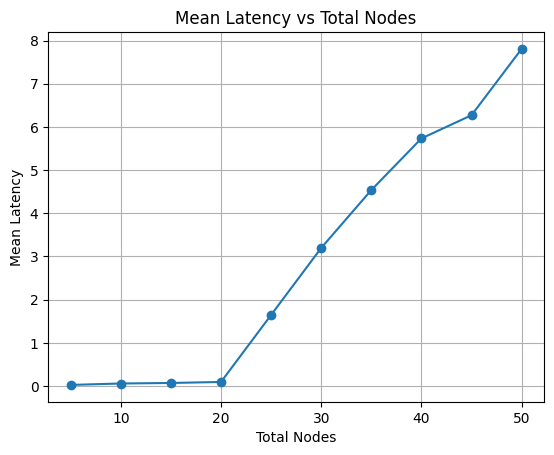

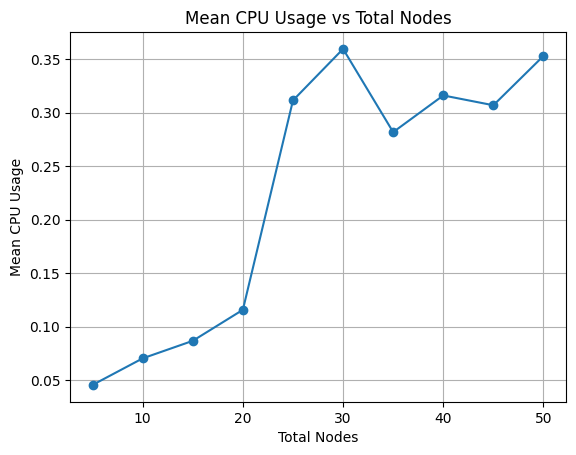

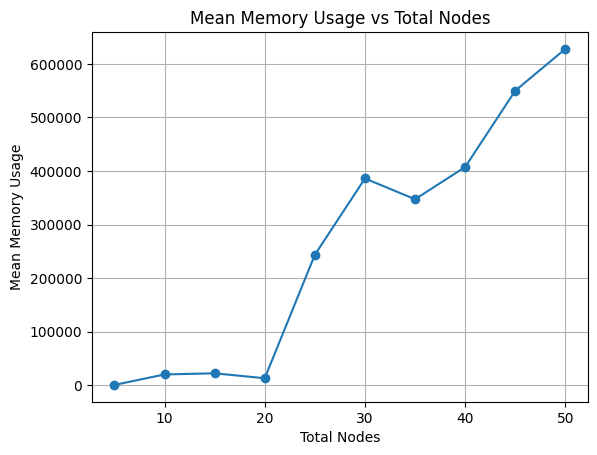

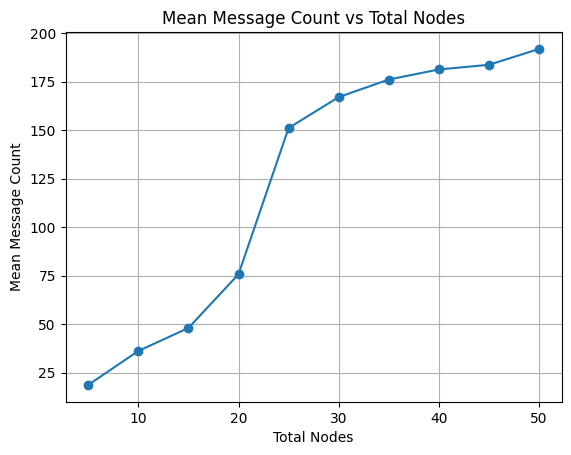

In [91]:
evaluation_log, message_log = read_logs("raft", 5, 50,5)
raft_result = evaluation(evaluation_log, duration=60,start_index=5)

leader 1
leader 1
leader 1
{'Mean Latency': dict_values([0.23146838347117107, 1.2689625905110287, 10.092386136183867]), 'Mean CPU Usage': dict_values([0.1430645161290323, 0.6890588235294118, 1.6773092369477915]), 'Mean Memory Usage': dict_values([99889.54838709677, 285161.9137254902, 1351943.1967871485]), 'Mean Message Count': dict_values([51.38333333333333, 133.9, 228.981981981982])}


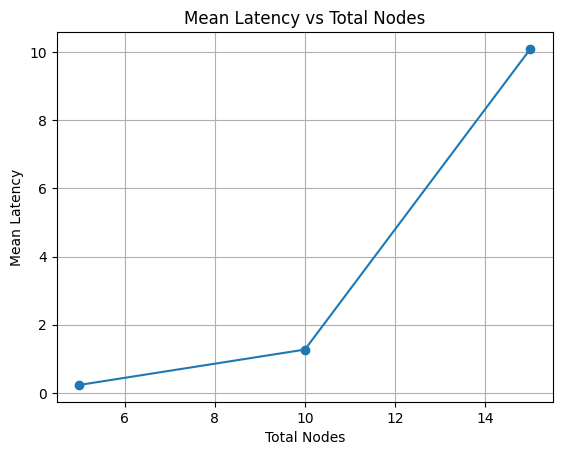

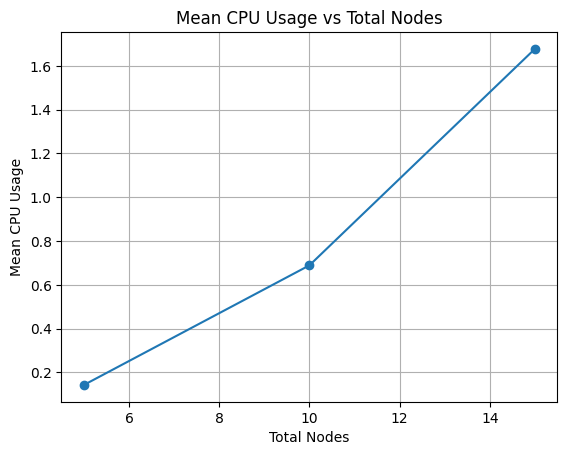

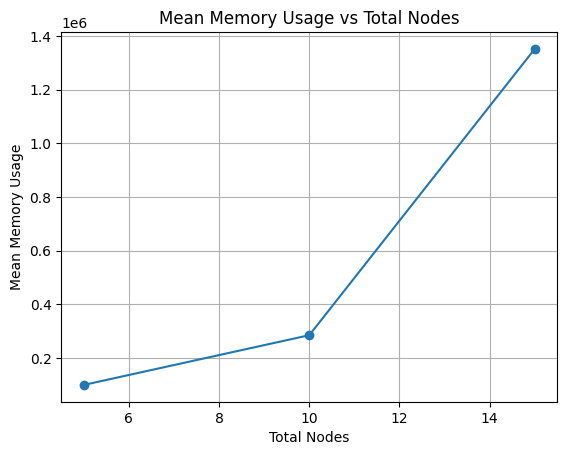

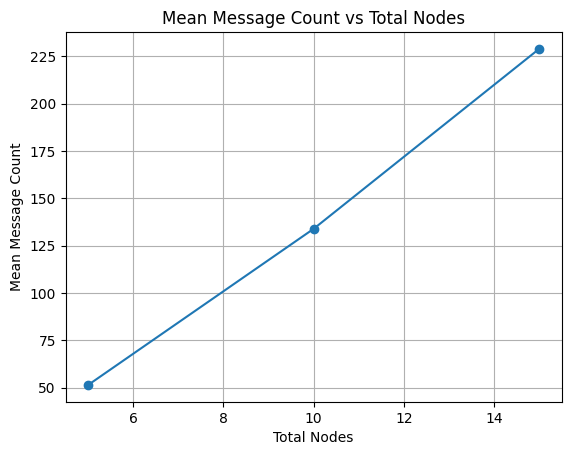

In [92]:
evaluation_log, message_log = read_logs("PBFT", 5, 15, 5)
pbft_result = evaluation(evaluation_log, duration=60,start_index=5)

leader 5
leader 10
leader 15
leader 20
leader 25
leader 30
leader 35
leader 40
leader 45
leader 50
{'Mean Latency': dict_values([0.012390874050281666, 0.026638024676162584, 0.03503101332145825, 0.043070581452599885, 0.3963477084425842, 0.21369498393257258, 0.21546810435819197, 0.23700823426729273, 0.16762063126353657, 0.21863834825830428]), 'Mean CPU Usage': dict_values([0.00369747899159664, 0.004075630252100841, 0.004502762430939227, 0.0049895178197064995, 0.034233937397034606, 0.037810413885180236, 0.03359325605900948, 0.03035486806187443, 0.02692554043234588, 0.02941386704789136]), 'Mean Memory Usage': dict_values([1445.6470588235295, 3872.268907563025, 3733.9226519337017, 4697.090146750524, 5432.092257001647, 6759.220293724967, 7544.581664910432, 7577.040946314832, 8431.397918334667, 9196.237312365976]), 'Mean Message Count': dict_values([1.3518518518518519, 1.4336283185840708, 1.4736842105263157, 1.4741379310344827, 2.04421768707483, 2.4086294416243654, 2.7117117117117115, 3.01012

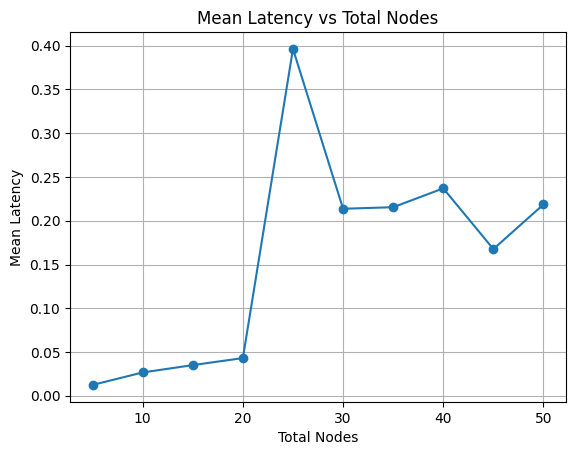

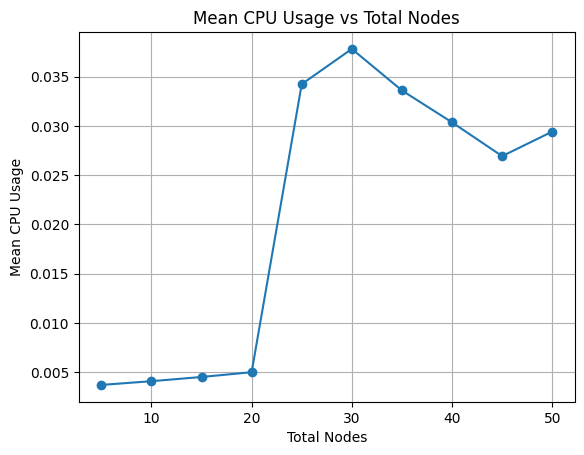

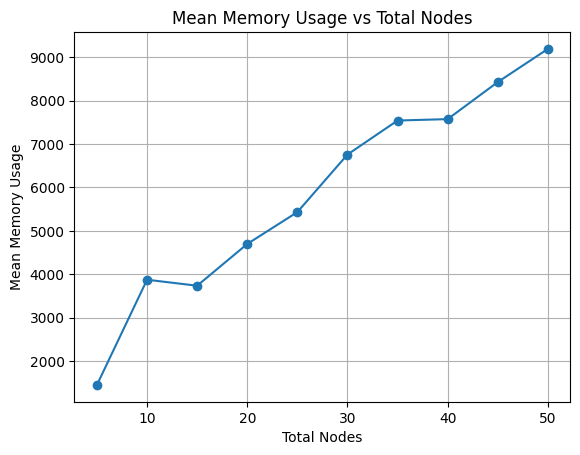

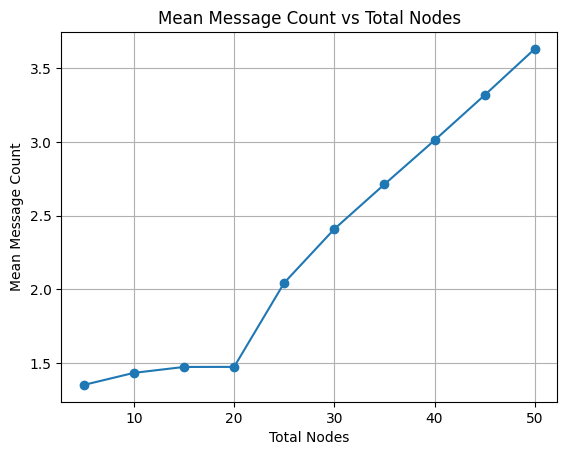

In [93]:
evaluation_log, message_log = read_logs("PoBT", 5, 50, 5)
pobt_result = evaluation(evaluation_log, duration=60,start_index=5)

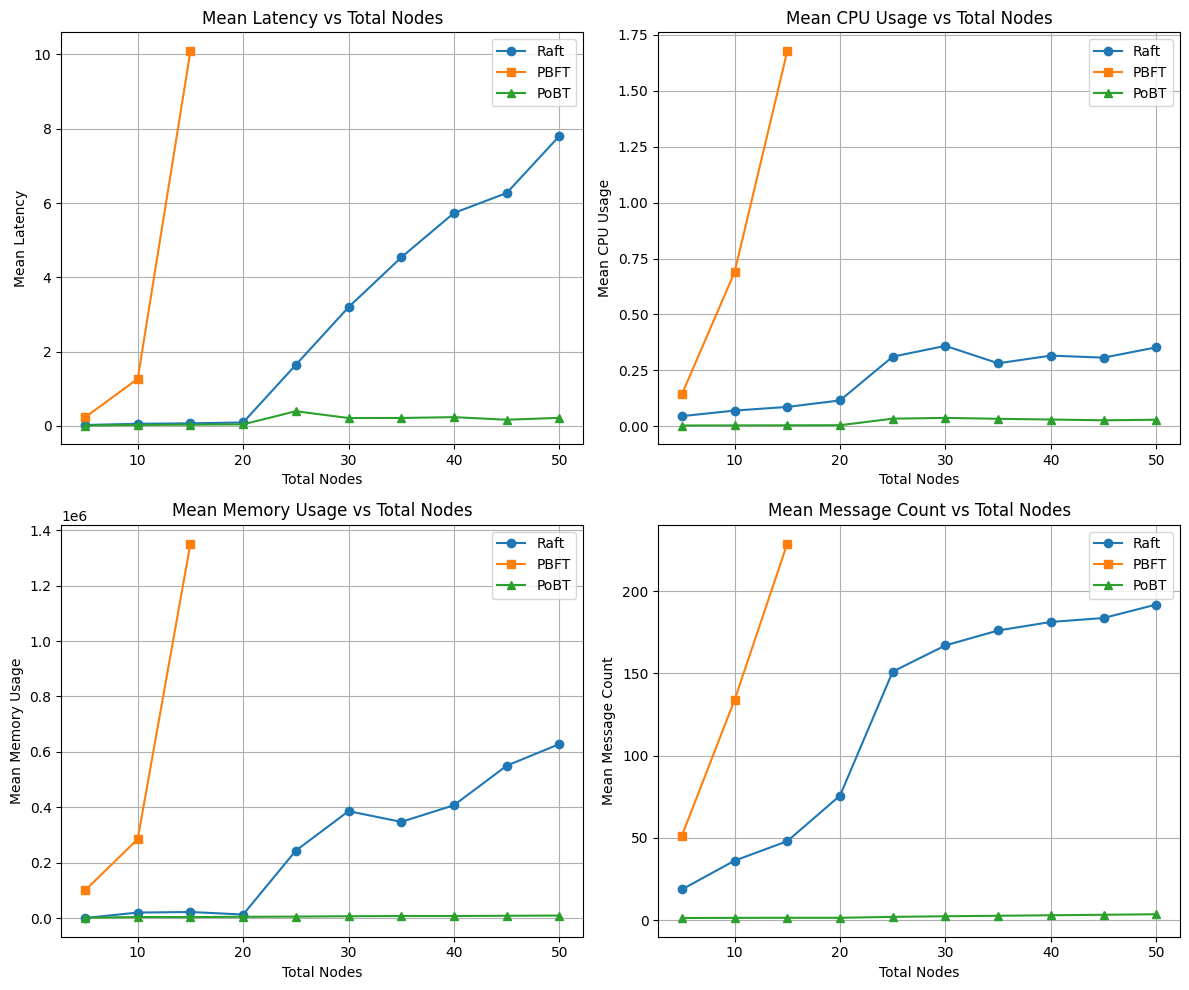

In [95]:
names = ["Mean Latency", "Mean CPU Usage", "Mean Memory Usage", "Mean Message Count"]
models = ["Raft", "PBFT" ,"PoBT"]
keys = list(raft_result.keys())
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 array for easy indexing

for i, metric_name in enumerate(names):
    ax = axes[i]
    ax.set_title(f"{metric_name} vs Total Nodes")
    
    name = keys[i]

    # Plot Raft data
    if name in raft_result:
        ax.plot(raft_result[name].keys(), raft_result[name].values(), label="Raft", marker='o')

    # Plot PBFT data
    if name in pbft_result:
        ax.plot(pbft_result[name].keys(), pbft_result[name].values(), label="PBFT", marker='s')

    # Plot PoBT data
    if name in pobt_result:
        ax.plot(pobt_result[name].keys(), pobt_result[name].values(), label="PoBT", marker='^')

    ax.set_xlabel("Total Nodes")
    ax.set_ylabel(metric_name)
    ax.legend()
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("consensus_comparison_plots.png", dpi=300)
plt.show()